In [1]:
#default_exp augmentations

# Augmentations

> Utilities for creating augmentation pipelines mentioned in popular self supervised learning papers.

In [2]:
#export
from fastai.vision.all import *
from kornia.augmentation import augmentation as korniatfm
import torchvision.transforms as tvtfm
import kornia

In [3]:
#hide
# kornia.__version__ 0.4.1, '0.4.2+cf8e854'
# !pip install git+https://github.com/kornia/kornia
# torchvision.__version__ 0.8.2

In [4]:
#export
from typing import Callable, Tuple, Union, List, Optional, Dict, cast
from kornia.filters import GaussianBlur2d
class GaussianBlur(kornia.augmentation.AugmentationBase2D):
    #https://kornia.readthedocs.io/en/latest/_modules/kornia/augmentation/augmentation.html#GaussianBlur
    # Use this until kornia 0.4.2 released
    r"""Apply gaussian blur given tensor image or a batch of tensor images randomly.

    Args:
        kernel_size (Tuple[int, int]): the size of the kernel.
        sigma (Tuple[float, float]): the standard deviation of the kernel.
        border_type (str): the padding mode to be applied before convolving.
          The expected modes are: ``'constant'``, ``'reflect'``,
          ``'replicate'`` or ``'circular'``. Default: ``'reflect'``.
        return_transform (bool): if ``True`` return the matrix describing the transformation applied to each
            input tensor. If ``False`` and the input is a tuple the applied transformation wont be concatenated.
        same_on_batch (bool): apply the same transformation across the batch. Default: False.
        p (float): probability of applying the transformation. Default value is 0.5.

    Shape:
        - Input: :math:`(C, H, W)` or :math:`(B, C, H, W)`, Optional: :math:`(B, 3, 3)`
        - Output: :math:`(B, C, H, W)`

    Note:
        Input tensor must be float and normalized into [0, 1] for the best differentiability support.
        Additionally, this function accepts another transformation tensor (:math:`(B, 3, 3)`), then the
        applied transformation will be merged int to the input transformation tensor and returned.

    Examples:
        >>> rng = torch.manual_seed(0)
        >>> input = torch.rand(1, 1, 5, 5)
        >>> blur = GaussianBlur((3, 3), (0.1, 2.0), p=1.)
        >>> blur(input)
        tensor([[[[0.6699, 0.4645, 0.3193, 0.1741, 0.1955],
                  [0.5422, 0.6657, 0.6261, 0.6527, 0.5195],
                  [0.3826, 0.2638, 0.1902, 0.1620, 0.2141],
                  [0.6329, 0.6732, 0.5634, 0.4037, 0.2049],
                  [0.8307, 0.6753, 0.7147, 0.5768, 0.7097]]]])
    """

    def __init__(self, kernel_size: Tuple[int, int],
                 sigma: Tuple[float, float],
                 border_type: str = 'reflect',
                 return_transform: bool = False,
                 same_on_batch: bool = False,
                 p: float = 0.5) -> None:
        super(GaussianBlur, self).__init__(
            p=p, return_transform=return_transform, same_on_batch=same_on_batch, p_batch=1.)
        self.transform = GaussianBlur2d(kernel_size, sigma, border_type)

    def __repr__(self) -> str:
        return self.__class__.__name__ + f"({super().__repr__()})"

    def generate_parameters(self, batch_shape: torch.Size) -> Dict[str, torch.Tensor]:
        return dict()

    def apply_transform(self, input: torch.Tensor, params: Dict[str, torch.Tensor]) -> torch.Tensor:
        return self.transform(input)

In [5]:
#export
class RandomGaussianBlur(RandTransform):
    "Randomly apply gaussian blur with probability `p` with a value of s"
    order = 11
    def __init__(self, p=0.5, s=(8,32), same_on_batch=False, **kwargs): 
        store_attr()
        super().__init__(p=p, **kwargs)
        
    def encodes(self, x:TensorImage):
        if isinstance(self.s, tuple): s = np.random.randint(*self.s)
        if isinstance(self.s, list):  s = np.random.randint(*self.s)
        if isinstance(self.s, int):   s = self.s
        s2 = int(s/4)*2+1
        tfm = GaussianBlur((s2,s2),(s,s),same_on_batch=self.same_on_batch,p=1.)
        return tfm(x)

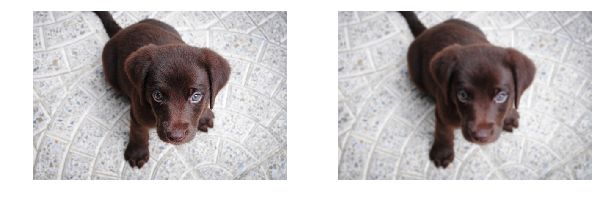

In [6]:
#hide
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))

pipe = Pipeline([ToTensor(), IntToFloatTensor()])
t1 = Pipeline([ToTensor(), IntToFloatTensor()])(img)

pipe = Pipeline([ToTensor(), IntToFloatTensor(), RandomGaussianBlur(1.,(1,32))], split_idx=0)
t2 = pipe(img)[0]

show_images([t1, t2], figsize=(10,20))

## Why kornia, torchvision or fastai?

These libraries are preferred over others for their batch transform capabilities. Being able to apply these transforms on batches allow us to use GPUs and get a speed up around ~10-20x depending on the input image size.

## Kornia

Kornia has ability to pass `same_on_batch` argument. If it's set to False, then augmentation will be randomly applied to elements of a batch.

`jitter`: Do color jitter or not `bw`: Do grayscale or not, `blur`: do blur or not, `resize_scale`: (min,max) scales for random resized crop, `resize_ratio`: (min,max) aspect ratios to use for random resized crop, `s`: scalar for color jitter, `blur_s`: (min, max) or single int for blur.

Their corresponding probabilities: `flip_p, jitter_p, bw_p, blur_p`

Kornia augmentation implementations have two additional parameters compare to TorchVision, return_transform and same_on_batch. The former provides the ability of undoing one geometry transformation while the latter can be used to control the randomness for a batched transformation. To enable those behaviour, you may simply set the flags to True.

**Recommendation:** Even though defaults work very well on many benchmark datasets it's always better to try different values and visualize your dataset before going further with training.

In [7]:
#export
def get_kornia_batch_augs(size,
                        rotate=True,
                        jitter=True,
                        bw=True,
                        blur=True,
                        resize_scale=(0.2, 1.0),
                        resize_ratio=(3/4, 4/3),
                        rotate_deg=30,
                        s=.6,  
                        blur_s=(4,32),
                        same_on_batch=False,
                        flip_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.3,
                        stats=imagenet_stats,
                        cuda=default_device().type == 'cuda',
                        xtra_tfms=[]):
    "Input batch augmentations implemented in kornia"
    tfms = []
    tfms += [korniatfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio, same_on_batch=same_on_batch)]
    tfms += [korniatfm.RandomHorizontalFlip(p=flip_p)]

    if rotate: tfms += [korniatfm.RandomRotation(rotate_deg, same_on_batch=same_on_batch)]
    
    if jitter: tfms += [korniatfm.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s, p=jitter_p, same_on_batch=same_on_batch)]
    if bw:     tfms += [korniatfm.RandomGrayscale(p=bw_p, same_on_batch=same_on_batch)]   
    if blur:   tfms += [RandomGaussianBlur(p=blur_p, s=blur_s, same_on_batch=same_on_batch)]

        
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

    tfms += xtra_tfms
    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

kornia RandomResizedCrop in overall looks more zoomed in. Might be related to sampling function used for scale?

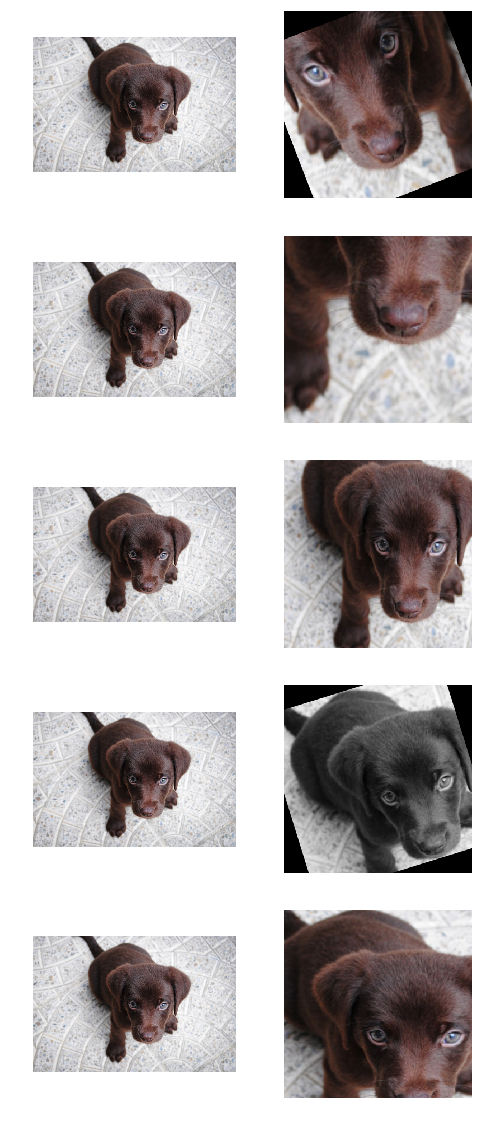

In [8]:
aug, n = get_kornia_batch_augs(336, resize_scale=(0.2,1), stats=imagenet_stats, cuda=False, same_on_batch=False), 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n): 
    show_image(t1,ax=ax[i][0])
    show_image(aug.decode(aug(t1)).clamp(0,1)[0], ax=ax[i][1])

GPU batch transforms are ~10x - ~20x faster than CPU depending on image size. Larger image sizes benefit from the GPU more.

In [9]:
xb = (torch.stack([t1]*32))
aug= get_kornia_batch_augs(336, resize_scale=(0.75,1),  stats=imagenet_stats, cuda=False)

In [10]:
%%timeit
out = aug(xb)

317 ms ± 51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
if torch.cuda.is_available():
    xb = xb.to(default_device())
    aug = get_kornia_batch_augs(336, resize_scale=(0.75,1), stats=imagenet_stats)

In [12]:
%%timeit 
if torch.cuda.is_available():
    out = aug(xb) # ignore: GPU warmup
    torch.cuda.synchronize()

26.8 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


`same_on_batch=False`

In [13]:
%%timeit
if torch.cuda.is_available():
    out = aug(xb)
    torch.cuda.synchronize()

27.1 ms ± 942 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
if torch.cuda.is_available():
    xb = xb.to(default_device())
    aug = get_kornia_batch_augs(336, resize_scale=(0.75,1), same_on_batch=True, stats=imagenet_stats)

`same_on_batch=True`

In [15]:
%%timeit
if torch.cuda.is_available():
    out = aug(xb)
    torch.cuda.synchronize()

17.4 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Torchvision

Torchvision doesn't have a `same_on_batch` parameter, it also doesn't support `jitter_p`.

In [16]:
#export
def get_torchvision_batch_augs(size,
                            rotate=True,
                            jitter=True,
                            bw=True,
                            blur=True,
                            resize_scale=(0.2, 1.0),
                            resize_ratio=(3/4, 4/3),
                            rotate_deg=30,
                            s=.6,  
                            blur_s=(4,32),
                            flip_p=0.5, bw_p=0.3, blur_p=0.3,
                            stats=imagenet_stats,
                            cuda=default_device().type == 'cuda',
                            xtra_tfms=[]):
    "Input batch augmentations implemented in torchvision"
    tfms = []
    tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    tfms += [tvtfm.RandomHorizontalFlip(p=flip_p)]
    
    if rotate: tfms += [tvtfm.RandomRotation(rotate_deg)]
            
    if jitter: tfms += [tvtfm.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)]
    if bw:     tfms += [tvtfm.RandomGrayscale(p=bw_p)]   
    if blur:   tfms += [RandomGaussianBlur(p=blur_p, s=blur_s)]
        
    tfms += xtra_tfms
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

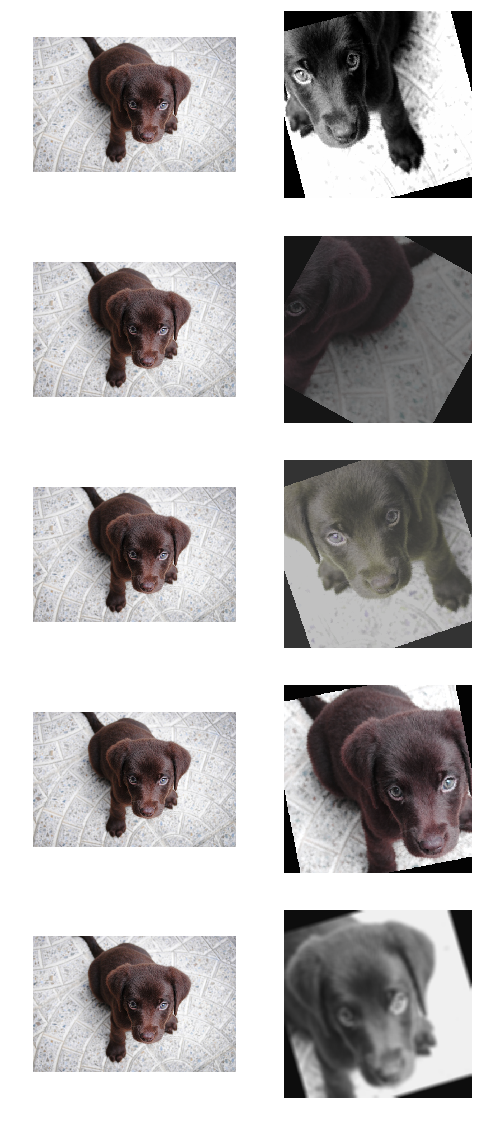

In [17]:
aug, n = get_torchvision_batch_augs(336, resize_scale=(0.2, 1), stats=imagenet_stats, cuda=False), 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n): 
    show_image(t1,ax=ax[i][0])
    show_image(aug.decode(aug(t1)).clamp(0,1)[0], ax=ax[i][1])

Torchvision is slightly faster than kornia with `same_on_batch=False`.

In [18]:
xb = (torch.stack([t1]*32))
aug= get_torchvision_batch_augs(336, resize_scale=(0.75,1), stats=imagenet_stats, cuda=False)

In [19]:
%%timeit
out = aug(xb)

962 ms ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
if torch.cuda.is_available():
    xb = xb.to(default_device())
    aug = get_torchvision_batch_augs(336, resize_scale=(0.75,1), stats=imagenet_stats)

In [21]:
%%timeit
if torch.cuda.is_available():
    out = aug(xb)
    torch.cuda.synchronize()

21.3 ms ± 467 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Fastai

In fastai few of the batch transforms are named differently, that is why it is not used as first choice. There might be better or worse implementation difference. Although, in general fastai has a faster and more accurate batch transform through a composition function called `setup_aug_tfms`.

Here, `max_lightning` for color jitter magnitude.

Fastai is as fast as the combination of kornia and torchvision, but it should be noted that `RandomResizedCropGPU` applies same crop to all elements (which is probably fine) similar to torchvision and color jittering is implemented in 4 separate transforms.

In [22]:
#export
def get_fastai_batch_augs(size,
                        rotate=True,
                        jitter=True,
                        bw=True,
                        blur=True,
                        min_scale=0.2,
                        resize_ratio=(3/4, 4/3),
                        max_lighting=0.2,
                        rotate_deg=30,
                        s=.6,  
                        blur_s=(8,32),
                        same_on_batch=False,
                        flip_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.3,
                        stats=imagenet_stats,
                        cuda=default_device().type == 'cuda',
                        xtra_tfms=[]):
    "Input batch augmentations implemented in kornia"
    tfms = []
    tfms += [RandomResizedCropGPU((size, size), min_scale=min_scale, ratio=resize_ratio)]
    tfms += [Flip(p=flip_p)]
    
    if rotate: tfms += [Rotate(rotate_deg, batch=same_on_batch)]
    
    if jitter: 
        tfms += [Brightness(max_lighting=max_lighting, p=jitter_p, batch=same_on_batch)]
        tfms += [Contrast(max_lighting=max_lighting, p=jitter_p, batch=same_on_batch)]
        tfms += [Hue(max_hue=max_lighting/2, p=jitter_p, batch=same_on_batch)]
        tfms += [Saturation(max_lighting=max_lighting, p=jitter_p, batch=same_on_batch)]
    if bw:     tfms += [korniatfm.RandomGrayscale(p=bw_p, same_on_batch=same_on_batch)]   
    if blur:   tfms += [RandomGaussianBlur(p=blur_p, s=blur_s, same_on_batch=same_on_batch)]
    
        
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

    tfms += xtra_tfms
    tfms = setup_aug_tfms(tfms)
    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

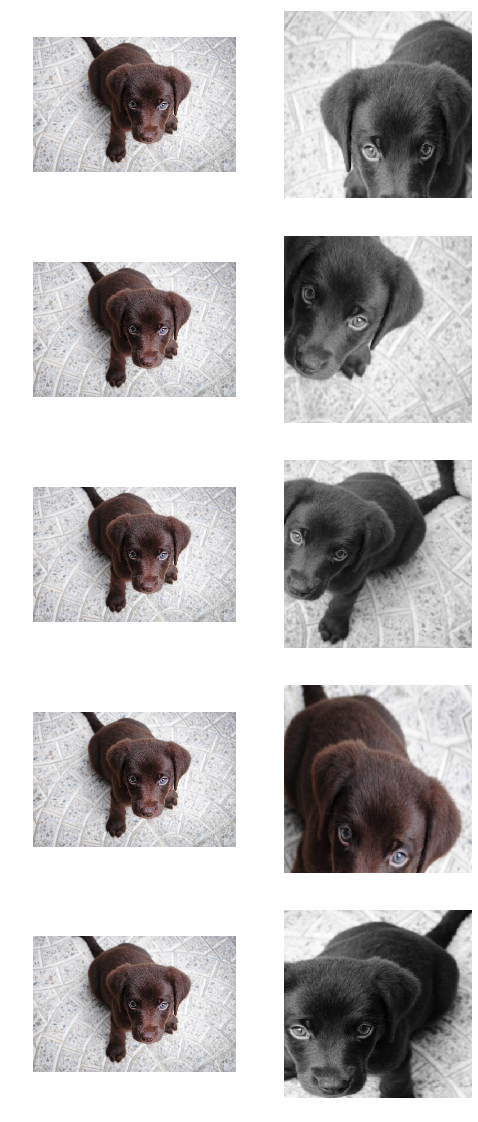

In [23]:
aug, n = get_fastai_batch_augs(336, min_scale=0.2, stats=imagenet_stats, cuda=False), 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n): 
    show_image(t1,ax=ax[i][0])
    show_image(aug.decode(aug(t1)).clamp(0,1)[0], ax=ax[i][1])

In [24]:
xb = (torch.stack([t1]*32))
aug = get_fastai_batch_augs(336, min_scale=0.75, stats=imagenet_stats, cuda=False)

In [25]:
%%timeit
out = aug(xb)

876 ms ± 97.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
if torch.cuda.is_available():
    xb = xb.to(default_device())
    aug = get_fastai_batch_augs(336, min_scale=0.75, stats=imagenet_stats)

In [27]:
%%timeit
if torch.cuda.is_available():
    out = aug(xb)
    torch.cuda.synchronize()

29.9 ms ± 507 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Kornia + Torchvision + Fastai

Here we use `RandomResizedCrop` from torchvision and keep the remaining augmentations same as kornia. This is kind of best of both worlds - fast and diverse augmentations. 

Also, `Rotate` from fastai is used for reflection padding.

In [28]:
#export
def get_batch_augs(size,
                    rotate=True,
                    jitter=True,
                    bw=True,
                    blur=True,
                    resize_scale=(0.2, 1.0),
                    resize_ratio=(3/4, 4/3),
                    rotate_deg=30,
                    s=.6,  
                    blur_s=(4,32),
                    same_on_batch=False,
                    flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.3,
                    stats=imagenet_stats,
                    cuda=default_device().type == 'cuda',
                    xtra_tfms=[]):
    "Input batch augmentations implemented in tv+kornia+fastai"
    tfms = []
    tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    tfms += [korniatfm.RandomHorizontalFlip(p=flip_p)]

    if rotate: tfms += [Rotate(max_deg=rotate_deg, p=rotate_p, batch=same_on_batch)]

    if jitter: tfms += [korniatfm.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s, p=jitter_p, same_on_batch=same_on_batch)]
    if bw:     tfms += [korniatfm.RandomGrayscale(p=bw_p, same_on_batch=same_on_batch)]   
    if blur:   tfms += [RandomGaussianBlur(p=blur_p, s=blur_s, same_on_batch=same_on_batch)]
        
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

    tfms += xtra_tfms
    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

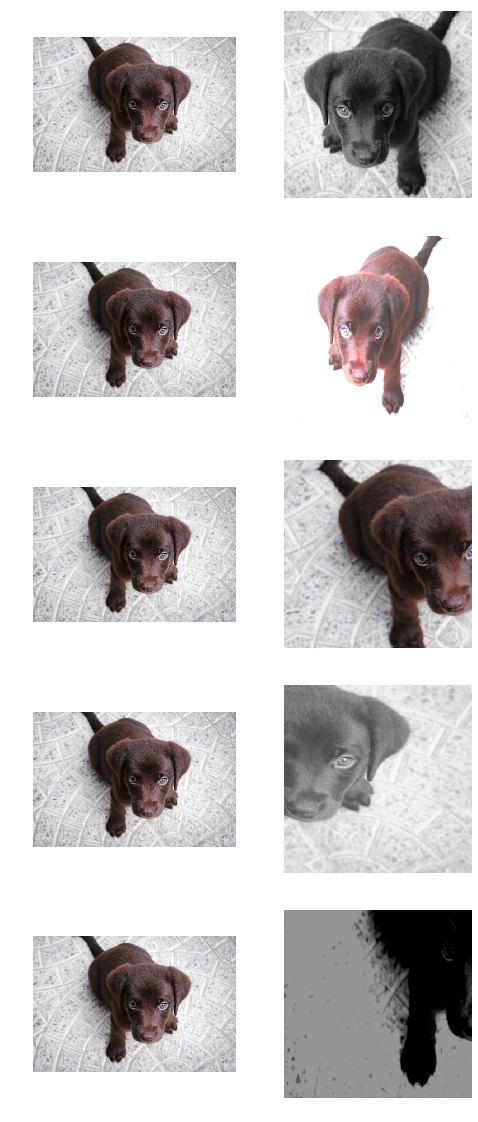

In [29]:
aug, n = get_batch_augs(336, resize_scale=(0.2, 1), stats=imagenet_stats,cuda=False), 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n): 
    show_image(t1,ax=ax[i][0])
    show_image(aug.decode(aug(t1)).clamp(0,1)[0], ax=ax[i][1])

Torchvision is slightly faster than kornia `same_on_batch=True`.

In [30]:
xb = (torch.stack([t1]*32))
aug= get_batch_augs(336, resize_scale=(0.75,1), stats=imagenet_stats, cuda=False)

In [31]:
%%timeit
out = aug(xb)

269 ms ± 62.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
if torch.cuda.is_available():
    xb = xb.to(default_device())
    aug = get_batch_augs(336, resize_scale=(0.75,1), stats=imagenet_stats)

In [33]:
%%timeit
if torch.cuda.is_available():
    out = aug(xb)
    torch.cuda.synchronize()

18.8 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Adding Extra tfms

You can simply add any batch transform by passing it as list to `xtra_tfms`.

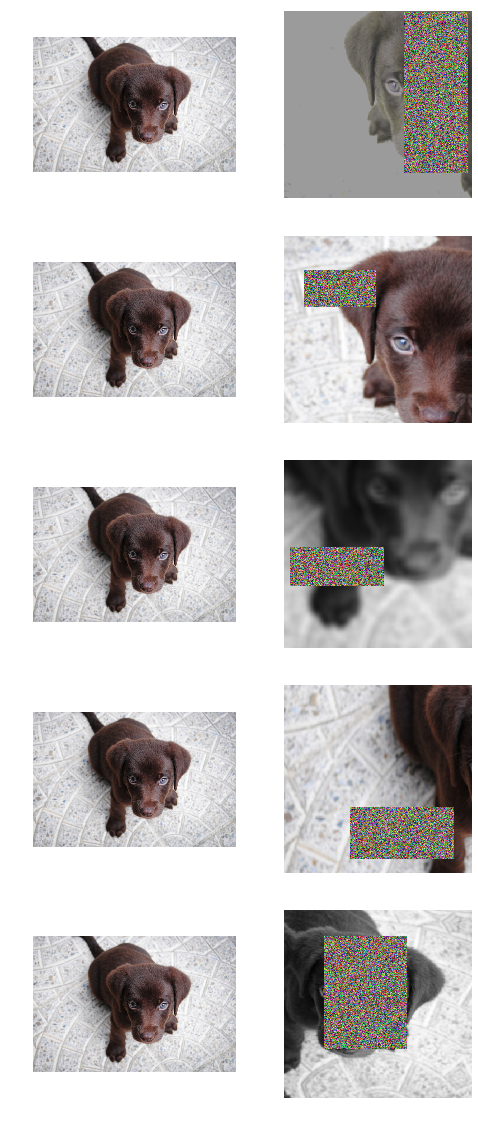

In [34]:
aug, n = get_batch_augs(336, resize_scale=(0.2, 1),  stats=imagenet_stats, cuda=False, xtra_tfms=[RandomErasing(p=1.)]), 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n): 
    show_image(t1,ax=ax[i][0])
    show_image(aug.decode(aug(t1)).clamp(0,1)[0], ax=ax[i][1])

## Export -

In [35]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01 - augmentations.ipynb.
Converted 02 - layers.ipynb.
Converted 03 - distributed.ipynb.
Converted 10 - simclr.ipynb.
Converted 11 - moco.ipynb.
Converted 12 - byol.ipynb.
Converted 13 - swav.ipynb.
Converted 20 - clip.ipynb.
Converted 21 - clip-moco.ipynb.
Converted index.ipynb.
